In [1]:
# hide
# default_exp model_fitting

from nbdev.showdoc import *

# CMR Repetitions Benchmark
> Pipeline for parameter fitting updated to respect the possibility of item repetition during encoding

## Configuring the Parameter Search
This time, we specify a log_likelihood function that accepts a presentations parameter indicating when an item was presented for encoding. This adds some runtime to the cost function, since a unique model is instantiated for each trial given that encoding patterns can vary between them.

In [2]:
# export
# hide

import numpy as np
from numba import njit
from instance_cmr.models import CMR

@njit(fastmath=True, nogil=True)
def cmr_rep_likelihood(
        trials, presentations, list_types, list_length, encoding_drift_rate, start_drift_rate, 
        recall_drift_rate, shared_support, item_support, learning_rate, 
        primacy_scale, primacy_decay, stop_probability_scale, 
        stop_probability_growth, choice_sensitivity):
    """
    Generalized cost function for fitting the InstanceCMR model optimized 
    using the numba library.
    
    Output scales inversely with the likelihood that the model and specified 
    parameters would generate the specified trials. For model fitting, is 
    usually wrapped in another function that fixes and frees parameters for 
    optimization.

    **Arguments**:
    - data_to_fit: typed list of int64-arrays where rows identify a unique 
        trial of responses and columns corresponds to a unique recall index.  
    - A configuration for each parameter of `InstanceCMR` as delineated in 
        `Formal Specification`.

    **Returns** the negative sum of log-likelihoods across specified trials 
    conditional on the specified parameters and the mechanisms of InstanceCMR.
    """

    likelihood = np.ones((len(trials), list_length))
    
    # we can use the same model for list types 1 and 2
    stable_models = [CMR(
            list_length, list_length, encoding_drift_rate, start_drift_rate, 
            recall_drift_rate, shared_support, item_support, learning_rate, 
            primacy_scale, primacy_decay, stop_probability_scale, 
            stop_probability_growth, choice_sensitivity), 
                    CMR(
            int(list_length/2), list_length, encoding_drift_rate, start_drift_rate, 
            recall_drift_rate, shared_support, item_support, learning_rate, 
            primacy_scale, primacy_decay, stop_probability_scale, 
            stop_probability_growth, choice_sensitivity)]
    stable_models[0].experience(np.eye(list_length, list_length))
    stable_models[1].experience(np.eye(int(list_length/2), int(list_length/2))[np.repeat(np.arange(int(list_length/2)), 2)])

    for trial_index in range(len(trials)):

        item_count = np.max(presentations[trial_index])+1
        
        if list_types[trial_index] > 2:
            model = CMR(
                item_count, list_length, encoding_drift_rate, start_drift_rate, 
                recall_drift_rate, shared_support, item_support, learning_rate, 
                primacy_scale, primacy_decay, stop_probability_scale, 
                stop_probability_growth, choice_sensitivity)

            model.experience(np.eye(item_count, item_count)[presentations[trial_index]])
        else:
            model = stable_models[list_types[trial_index]-1]
            
        trial = trials[trial_index]

        model.force_recall()
        for recall_index in range(len(trial) + 1):

            # identify index of item recalled; if zero then recall is over
            if recall_index == len(trial) and len(trial) < item_count:
                recall = 0
            elif trial[recall_index] == 0:
                recall = 0
            else:
                recall = presentations[trial_index][trial[recall_index]-1] + 1

            # store probability of and simulate recalling item with this index
            likelihood[trial_index, recall_index] = \
                model.outcome_probabilities(model.context)[recall]

            if recall == 0:
                break
            model.force_recall(recall)

        # reset model to its pre-retrieval (but post-encoding) state
        model.force_recall(0)

    return -np.sum(np.log(likelihood))

def cmr_rep_objective_function(data_to_fit, presentations, list_types, list_length, fixed_parameters, free_parameters):
    """
    Generates and returns an objective function for input to support search 
    through parameter space for ICMR model fit using an optimization function.

    Arguments:  
    - fixed_parameters: dictionary mapping parameter names to values they'll 
        be fixed to during search, overloaded by free_parameters if overlap  
    - free_parameters: list of strings naming parameters for fit during search  
    - data_to_fit: array where rows identify a unique trial of responses and 
        columns corresponds to a unique recall index

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of icmr_likelihood using the model 
    class, all parameters, and provided data.
    """
    return lambda x: cmr_rep_likelihood(data_to_fit, presentations, list_types, list_length, **{**fixed_parameters, **{
        free_parameters[i]:x[i] for i in range(len(x))}})

In [3]:
try:
    show_doc(cmr_murd_likelihood, title_level=3)
    show_doc(cmr_murd_objective_function, title_level=3)
except:
    pass

## Single-Subject Demo

In [4]:
from instance_cmr.datasets import *

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_repdata(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


In [5]:
lb = np.finfo(float).eps
hand_fit_parameters = {
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

cmr_rep_likelihood(trials[:48], presentations[:48], list_types[:48], list_length, **hand_fit_parameters)

3403.626205060291

In [6]:
%%timeit
cmr_rep_likelihood(trials[:48], presentations[:48], list_types[:48], list_length, **hand_fit_parameters)

9.99 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


```
17 ms ± 60.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
```

Now we perform the single subject fitting...

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = cmr_rep_objective_function(
    trials[:48], presentations[:48], list_types[:48], list_length, {}, free_parameters)

result = differential_evolution(cost_function, bounds, disp=True)
print(result)

For the first subject in our murd_trials data structure, the function runs pretty slowly compared to my primary baseline code and returns an output with the following attributes:

```
     fun: 1896.0488460602892
     jac: array([-1.37909932e+02, -6.49760292e+01,  3.80207664e+01,  3.89726438e+01,
       -1.08398125e+00,  4.96122311e+01, -7.76151406e+00,  7.50098939e+00,
        1.87378446e+03,  5.77529363e+01, -6.19131701e+00])
 message: 'Optimization terminated successfully.'
    nfev: 7656
     nit: 43
 success: True
       x: array([7.38333200e-01, 9.11533659e-01, 9.45503715e-01, 1.59987819e-01,
       5.26298280e-01, 3.21809937e-01, 8.64043185e-01, 1.10011958e+00,
       1.24608414e-03, 2.67508370e-01, 2.93468878e+00])
```

The `x` attribute of the result object contains the best parameter configuration found, while the `fun` attribute represents the overall cost of the configuration as computed with our specified cost function. 

## Visualize Fit With Variable Presentations

We modify `visualize_fit` to simulate unique specified encoding sequences.

In [15]:
# export

import pandas as pd
import seaborn as sns
from psifr import fr
import matplotlib.pyplot as plt
from tqdm import tqdm

def visualize_rep_fit(model_class, parameters, data, presentations, 
                      list_types, experiment_count=1000, savefig=False):
    """
    Apply organizational analyses to visually compare the behavior of the model 
    with these parameters against specified dataset.
    """
    
    # generate simulation data from model
    sim = []
    for experiment in tqdm(range(experiment_count)):
        for trial_index, presentation in enumerate(presentations):
            
            item_count = np.max(presentation)+1
            model = model_class(**{'item_count': item_count, **parameters})

            # simulate study events
            try:
                model.experience(np.eye(model.item_count, model.item_count + 1, 1)[presentation])
            except ValueError:
                model.experience(np.eye(model.item_count, model.item_count)[presentation])
            
            # add study events to dataframe
            for presentation_index, presentation_event in enumerate(presentation):
                sim += [[experiment*10000 + trial_index, 0, 'study', presentation_index+1, int(presentation_event), 
                         list_types[trial_index]]]
            
            # simulate and add recall events to dataframe
            sim += [[experiment*10000 + trial_index, 0, 'recall', i + 1, o, list_types[trial_index]]
                    for i, o in enumerate(model.free_recall())]
                            
    sim = pd.DataFrame(sim, columns=[
        'subject', 'list', 'trial_type', 'position', 'item', 'condition'])
    sim_data = fr.merge_free_recall(sim, list_keys=['condition'])
    
    # generate simulation-based spc, pnr, lag_crp
    sim_spc = fr.spc(sim_data).reset_index()
    sim_pfr = fr.pnr(sim_data).query('output <= 1').reset_index()
    sim_lag_crp = fr.lag_crp(sim_data).reset_index()
    
    # generate data-based spc, pnr, lag_crp
    data_spc = fr.spc(data).reset_index()
    data_pfr = fr.pnr(data).query('output <= 1').reset_index()
    data_lag_crp = fr.lag_crp(data).reset_index()
    
    # combine representations
    print('combine spc')
    data_spc['Source'] = 'Data'
    sim_spc['Source'] = model_class.__name__
    combined_spc = pd.concat([data_spc, sim_spc], axis=0)
    
    print('combine pfr')
    data_pfr['Source'] = 'Data'
    sim_pfr['Source'] = model_class.__name__
    combined_pfr = pd.concat([data_pfr, sim_pfr], axis=0)
    
    print('combine crp')
    data_lag_crp['Source'] = 'Data'
    sim_lag_crp['Source'] = model_class.__name__
    combined_lag_crp = pd.concat([data_lag_crp, sim_lag_crp], axis=0)
    
    # generate plots of result
    # spc
    print('spc')
    g = sns.FacetGrid(dropna=False, data=combined_spc)
    g.map_dataframe(sns.lineplot, x='input', y='recall', hue='Source')
    g.set_xlabels('Serial position')
    g.set_ylabels('Recall probability')
    plt.title('P(Recall) by Serial Position Curve')
    g.add_legend()
    g.set(ylim=(0, 1))
    if savefig:
        plt.savefig('figures/{}_fit_spc.jpeg'.format(model_class.__name__), bbox_inches='tight')
    else:
        plt.show()
    
    #pdf
    print('pfr')
    h = sns.FacetGrid(dropna=False, data=combined_pfr)
    h.map_dataframe(sns.lineplot, x='input', y='prob', hue='Source')
    h.set_xlabels('Serial position')
    h.set_ylabels('Probability of First Recall')
    plt.title('P(First Recall) by Serial Position')
    h.add_legend()
    h.set(ylim=(0, 1))
    if savefig:
        plt.savefig('figures/{}_fit_pfr.jpeg'.format(model_class.__name__), bbox_inches='tight')
    else:
        plt.show()
    
    # lag crp
    print('lag crp')
    max_lag = 5
    filt_neg = f'{-max_lag} <= lag < 0'
    filt_pos = f'0 < lag <= {max_lag}'
    i = sns.FacetGrid(dropna=False, data=combined_lag_crp)
    i.map_dataframe(
        lambda data, **kws: sns.lineplot(data=data.query(filt_neg),
                                         x='lag', y='prob', hue='Source', **kws))
    i.map_dataframe(
        lambda data, **kws: sns.lineplot(data=data.query(filt_pos),
                                         x='lag', y='prob', hue='Source', **kws))
    i.set_xlabels('Lag')
    i.set_ylabels('Recall Probability')
    plt.title('Recall Probability by Item Lag')
    i.add_legend()
    i.set(ylim=(0, 1))
    if savefig:
        plt.savefig('figures/{}_fit_crp.jpeg'.format(model_class.__name__), bbox_inches='tight')
    else:
        plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


combine spc
combine pfr
combine crp
spc
pfr
lag crp


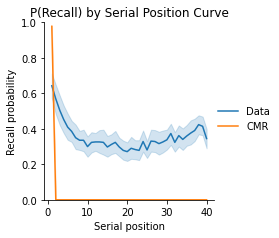

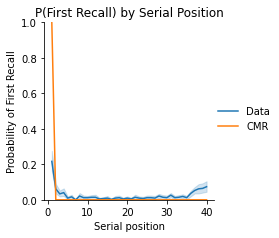

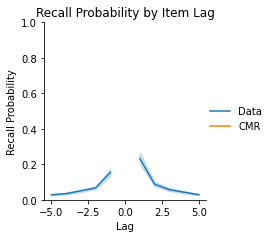

In [16]:
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

parameters = {
    'presentation_count': list_length, 
    'sampling_rule': 0
}

stored_result = [7.34339302e-01, 5.77280522e-01, 9.32318711e-01, 3.95388799e-01,
       2.22044605e-16, 1.00000000e+00, 5.52186306e-01, 2.65079941e+01,
       2.36119108e-02, 9.12422168e-02, 5.76025967e+00]

visualize_rep_fit(
    CMR, {**parameters, **{free_parameters[i]:stored_result[i] for i in range(len(stored_result))}},
    events[events.condition==1], presentations[list_types==1], list_types[list_types==1], 
    experiment_count=100, savefig=True
)

In [17]:
events[events.condition==1]

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
40,1,2,0,1,7.0,True,True,0,False,1
41,1,2,1,2,11.0,True,True,0,False,1
42,1,2,2,3,NaN,True,False,0,False,1
43,1,2,3,4,NaN,True,False,0,False,1
44,1,2,4,5,3.0,True,True,0,False,1
...,...,...,...,...,...,...,...,...,...,...
67195,37,48,35,36,6.0,True,True,0,False,1
67196,37,48,36,37,NaN,True,False,0,False,1
67197,37,48,37,38,NaN,True,False,0,False,1
67198,37,48,38,39,5.0,True,True,0,False,1
